### Movie Recommendation System - Ronit Malik 

The following code below is written to create a movie recommendation system.

In [ ]:
pip install -U scikit-learn

In [ ]:
!pip install numpy==1.14.0
!pip install scipy==1.1.0
!pip install Scikit-learn==0.22 

In [ ]:
!pip install fuzzywuzzy
!pip install matplotlib

In [ ]:
!pip uninstall numpy

In [ ]:
!pip install seaborn 

In [ ]:
#Importing all the library 

import pandas as pd 
import numpy as np 
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from scipy.sparse.linalg import svds
import random 

sns.set_style("darkgrid")



import warnings 
warnings.simplefilter(action='ignore', category='FutureWarning')

In [ ]:
# Now let us fetch the movielens dataset that will be used for thesis and to build a recommendation system.
# The link to download the movielens dataset is http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# However we do not want to download this on the local drive as we are working on google colab, therefore we can download the zip file directly 
# on google colab by using the !wget command 

#The following code below will download the zip file 

!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [ ]:
# The following code above will download the entire zip file, however we are not interested in the zip file, we are concerned about the files 
# inside the zip file, therefore now we will unzip the file that has been downloaded above and extract all the files in the zip folder. 
# This can be done by using the !unzip command 

!unzip ml-latest-small.zip

In [ ]:
# We can use the !ls command to check if the files have been downloaded correctly 

!ls

In [ ]:
# Now we can load the following csv file that we unzip above and create a dataframe 

links = pd.read_csv("ml-latest-small/links.csv")

tags = pd.read_csv("ml-latest-small/tags.csv")

ratings = pd.read_csv("ml-latest-small/ratings.csv")

movies = pd.read_csv("ml-latest-small/movies.csv")


We can perform basic data exploration to get a better understanding of the type of data we are working with. 

In [ ]:
ratings.head()

In [ ]:
# let view the dataset and see the type of data types we have and the shape of the dataframe 
# We can create a function which would save time and print the shape for all the dataframe 

def dataset_shape(dataset_shape):
  a = ratings.shape
  b = movies.shape
  c = tags.shape 
  d = links.shape
  
  return(a, b, c, d)

dataset_shape(dataset_shape)

As seen above the following function above that letters from a to d have been assigned for the shape of each dataframe, as seen above 



*   Ratings = 100,836 rows and 4 columns 

*   Movies = 9742 rows and 3 columns 

*   tags = 3683 rows and 4 columns 

*   links = 9742 rows and 3 columns 






In [ ]:
# Let us see the different coloumns in the dataset given above 
# Creating a function to view coloumns in the dataset 

def dataset_coloumn(dataset_coloumn):
  a = ratings.columns
  b = movies.columns
  c = tags.columns 
  d = links.columns
  
  return(a, b, c, d)

dataset_coloumn(dataset_coloumn)

As seen above the following function above that letters from a to d have been assigned for the columns of each dataframe, as seen above 



*   Ratings = (['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

*   Movies = (['movieId', 'title', 'genres'], dtype='object')

*   tags = (['userId', 'movieId', 'tag', 'timestamp'], dtype='object')

*   links = (['movieId', 'imdbId', 'tmdbId'], dtype='object')


As seen from the different columns in the dataset, one common column in every dataset is movieID, this will play an important role while mergering different dataset together, as that can act as a reference point to merge datasets 

As rating plays an important role for modelling and recommendation both for content based and collaborative filtering, let us look more into the ratings dataset and understand it. 

In [ ]:
# Exploring the type of data types in the dataset 
def dataset_info():
  a = ratings.info()
  b = movies.info()
  c = tags.info()
  d = links.info()

  return(a, b, c, d)

dataset_info()


In [ ]:
#randomly shuffling the rows to avoid any bias 

random.seed(4321)

ratings =ratings.iloc[np.random.permutation(ratings.index)].reset_index(drop=True)
movies = movies.iloc[np.random.permutation(movies.index)].reset_index(drop=True)

In [ ]:
#Exploring the rating dataset 

number_of_ratings = len(ratings)
number_of_movies = ratings['movieId'].nunique()
number_of_users = ratings['userId'].nunique()

print(f"Number of ratings: {number_of_ratings}")
print(f"Number of unique movieId's: {number_of_movies}")
print(f"Number of unique users: {number_of_users}")
print(f"Average number of ratings per user: {round(number_of_ratings/number_of_users, )}")
print(f"Average number of ratings per movie: {round(number_of_ratings/number_of_movies, )}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165
Average number of ratings per movie: 10


Now let us explore how many movies have been rated by each user 

In [ ]:
# Visualising any missing values in the dataset 

ratings.isnull().count()

userId       100836
movieId      100836
rating       100836
timestamp    100836
dtype: int64

In [ ]:
#let's take a look at users' rating counts. We can do this using pandas' groupby() and count() 
# which groups the data by userId's and counts the number of ratings for each userId.

def user_rating_freq(user_rating_freq):
  user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
  user_freq.columns = ['userId', 'number_of_ratings']
  a = user_freq.head(10)
  b = user_freq.tail(10)

  return(a, b)

#Calling the function 
user_rating_freq(user_rating_freq)

(   userId  number_of_ratings
 0       1                232
 1       2                 29
 2       3                 39
 3       4                216
 4       5                 44
 5       6                314
 6       7                152
 7       8                 47
 8       9                 46
 9      10                140,      userId  number_of_ratings
 600     601                101
 601     602                135
 602     603                943
 603     604                100
 604     605                221
 605     606               1115
 606     607                187
 607     608                831
 608     609                 37
 609     610               1302)

# Data Pre-processing and Cleaning for rating and movies dataset 

The following function above lets us see the number of movies rated by each user, we can see that there are some user who have rated 100+ movies and some users who have rated less than 50 movies. 

We can also visualise the following table above in a bar chart 


In [ ]:
# For the purpose of modelling we will only consider users who have rated more than 50 movies, we will keep 50 movies as a minimum threshold for users rate
#Setting a threshold for the number of ratings per users should be more than 50 and creating a new dataset 

print(f"Number of unique movieId's: {number_of_movies}")

# As seen we have 9724 movies in the dataset, therefore the threshold will be for the user to have rated atleast 0.5% movies in the entire dataset
# for modelling significance 

# Setting Threshold 

user_threshold = 0.005

min_threshold = round(number_of_movies * user_threshold)

print(f"User rating for movie threshold is: {min_threshold}")

Number of unique movieId's: 9724
User rating for movie threshold is: 49


As seen above, we have set a user threshold of 0.5% which represents that a user should meet that threshold for the purpose of modelling

In [ ]:
# Now we apply this threshold to our original rating dataset to only take users who have rated more than the minimum threshold. 
# Creating a new dataframe where we will have users which have met the minimum threshold 
## We are creating a variable A to store all the users that have met the threshold
### Then we create a variable called threshold where we store all the userID and Ratings

user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'number_of_ratings']

threshold_setting = user_freq['number_of_ratings'] > min_threshold
threshold_data = user_freq[threshold_setting]
threshold_data.head()


,userId,number_of_ratings
0,1,232
3,4,216
5,6,314
6,7,152
9,10,140


Now we have created a new dataframe above which all list of all the users that have rated above the minimum threshold, now this data will be used to merge with the original ratings dataset with only users meeting the minimum threshold. 

In [ ]:
# Merging the data to create a dataset with the updated list of users who have met the minimum threshold. 

ratings_with_user_threshold = threshold_data.merge(ratings, on='userId', how='left')
ratings_with_user_threshold.head()

,userId,number_of_ratings,movieId,rating,timestamp
0,1,232,1196,5.0,964981827
1,1,232,6,4.0,964982224
2,1,232,3702,5.0,964983737
3,1,232,2478,4.0,964984169
4,1,232,1025,5.0,964982791


In [ ]:
ratings_with_user_threshold.shape

(93812, 5)

Text(0.5, 1.0, 'Distribution of movie ratings')

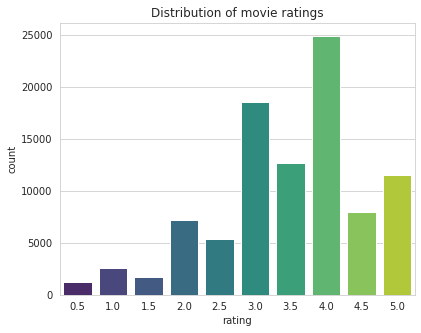

In [ ]:
#Let us visualise the dataset 
# We can see that the most common rating here is 4, whereas the lowest rating is around ~0.5 - 1 

sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings_with_user_threshold, palette="viridis")
plt.title("Distribution of movie ratings")


As seen from the visualisation above, a lot of users have given a rating of 4 for most of the movies

After preprocessing our dataset with minimum threshold, let us clean the data and remove the columns we do not need. 

In [ ]:
#droping the number of ratings per user as it has no significance for modelling

ratings_data = ratings_with_user_threshold.drop(labels='number_of_ratings',axis=1) 
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1196,5.0,964981827
1,1,6,4.0,964982224
2,1,3702,5.0,964983737
3,1,2478,4.0,964984169
4,1,1025,5.0,964982791


The next step is to check if our code worked, if it did it should not show users who have not met the minimum threshold in the dataset, when the code below is executed it should show a blank output which will show that the user has not met the minimum requirement. 

In [ ]:
# Here we are taking userID 2 as an example to check if there are any records showing on the updated dataframe. 
# The output should show blank as there is no record for userID 2 as it has not met the minimum requirement  

ratings_data.loc[ratings_data['userId'] == 2]

,userId,movieId,rating,timestamp


Now the data for ratings has been prepared and ready to be used for modelling, now let us look at the movies dataset and clean that before merging it. 

In [ ]:
#Let us view the movies dataset the first 10 rows 

movies.head(10)

,movieId,title,genres
0,66320,"11th Hour, The (2007)",[Documentary]
1,148667,John Mulaney: The Comeback Kid (2015),[Comedy]
2,7266,"Lost Skeleton of Cadavra, The (2002)","[Comedy, Horror, Sci-Fi]"
3,102338,Shaolin Temple (Shao Lin si) (1976),"[Action, Adventure, Drama]"
4,4465,"Accused, The (1988)",[Drama]
5,7028,Quick Change (1990),"[Comedy, Crime]"
6,4704,Hatari! (1962),"[Adventure, Comedy]"
7,6811,PCU (1994),[Comedy]
8,870,Gone Fishin' (1997),[Comedy]
9,68237,Moon (2009),"[Drama, Mystery, Sci-Fi, Thriller]"


In [ ]:
# Let us look for any null values in the dataset 

movies.isnull().sum(axis=0)

movieId    0
title      0
genres     0
dtype: int64

There is no null values present in the movies dataset, the next thing that can be done is to remove the "|" from the genre column 

In [ ]:
# First we will convert the genre from string to a list, becasue the current data takes into account the pipe funtion
## so we can remove that to make it easier 

movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

Now that the pipe function is removed, let us look that most popular genre in the movies dataset, this can be done by using the count function 

In [ ]:
# We need to check how many movie genre are there, 
# We can use Python's Counter to create a dictionary containing frequency counts of each genre in our dataset.

from collections import Counter

genres_counts = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")
genres_counts

There are 20 genre labels.


Counter({'(no genres listed)': 34,
         'Action': 1828,
         'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Crime': 1199,
         'Documentary': 440,
         'Drama': 4361,
         'Fantasy': 779,
         'Film-Noir': 87,
         'Horror': 978,
         'IMAX': 158,
         'Musical': 334,
         'Mystery': 573,
         'Romance': 1596,
         'Sci-Fi': 980,
         'Thriller': 1894,
         'War': 382,
         'Western': 167})

In [ ]:
#Let's remove all movies having (no genres listed) as its genre label. We'll also remove this from our genre_counts dictionary.

movies = movies[movies['genres']!='(no genres listed)']

del genres_counts['(no genres listed)']

# Now let us look for the most popular genre
print("The 5 most common genres: \n", genres_counts.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


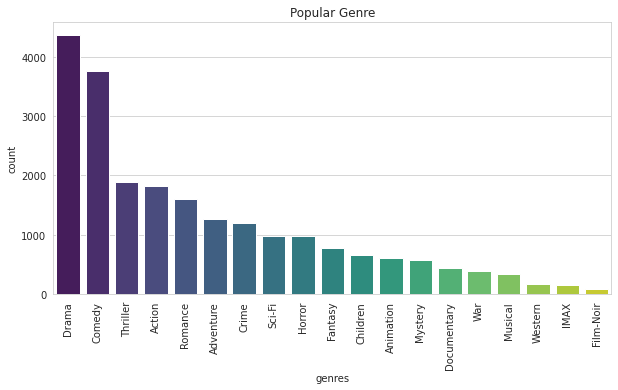

In [ ]:
# We can also visualise the genre popularity in a form of bar plot 
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.title("Popular Genre")
plt.show()

# Content - Based Recommendation System 

In [ ]:
#Let us load the clean and prepared data here again 

ratings_data = ratings_data

movies = movies

links = links

tags = tags

In [ ]:
# Here we are merging movies and ratings data together based on movieID 
content_based_movie_data = pd.merge(ratings_data, movies, on='movieId', how='left')
content_based_movie_data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1196,5.0,964981827,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]"
1,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]"
2,1,3702,5.0,964983737,Mad Max (1979),"[Action, Adventure, Sci-Fi]"
3,1,2478,4.0,964984169,¡Three Amigos! (1986),"[Comedy, Western]"
4,1,1025,5.0,964982791,"Sword in the Stone, The (1963)","[Animation, Children, Fantasy, Musical]"


In [ ]:
# Checking the shape of the dataset to see the shape. 

content_based_movie_data.shape 

(93812, 6)

As seen above, the dataset contains NaN values above, we will remove these NaN values as they have no predicting power 

In [ ]:
#Creating a new variable to store data after dropping the nan values 

after_Dropna = content_based_movie_data.dropna()
after_Dropna.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1196,5.0,964981827,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]"
1,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]"
2,1,3702,5.0,964983737,Mad Max (1979),"[Action, Adventure, Sci-Fi]"
3,1,2478,4.0,964984169,¡Three Amigos! (1986),"[Comedy, Western]"
4,1,1025,5.0,964982791,"Sword in the Stone, The (1963)","[Animation, Children, Fantasy, Musical]"


In [ ]:
#Double-checking the dataset to see if the NaN values are removed from the dataset 

after_Dropna.shape 

(93812, 6)

As seen above, after removing the NaN values from our dataset, the data has reduced from 16122 to 3875. We will be using this as our final data for modelling 

Now let us explore further the the number of rating recieved for each movieID, this will give a list of top 10 movies in our dataset based on user ranking, the user ranking will be a good measure to see this as we have set a minimum threshold of 0.5% for user. 

In [ ]:
# Looking at total rating recieved by movies
movie_freq = pd.DataFrame(after_Dropna.groupby('movieId').count()['rating']).reset_index()
movie_freq.head()

,movieId,rating
0,1,175
1,2,103
2,3,43
3,4,5
4,5,36


In [ ]:
# Let us merge the number of ratings back to the original dataframe 'after.dropna'
content_based_movie_afterna_aftermoviefreq = pd.merge(left=after_Dropna, right=movie_freq, on='movieId')
content_based_movie_afterna_aftermoviefreq.head()

,userId,movieId,rating_x,timestamp,title,genres,rating_y
0,1,1196,5.0,964981827,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186
1,4,1196,5.0,964538763,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186
2,7,1196,4.0,1106635996,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186
3,15,1196,5.0,1510572645,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186
4,16,1196,3.0,1377476993,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186


In [ ]:
# Let us rename the columns 
content_based_movie_afterna_aftermoviefreq.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)
content_based_movie_afterna_aftermoviefreq.head()

,userId,movieId,rating,timestamp,title,genres,numRatings
0,1,1196,5.0,964981827,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186
1,4,1196,5.0,964538763,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186
2,7,1196,4.0,1106635996,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186
3,15,1196,5.0,1510572645,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186
4,16,1196,3.0,1377476993,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186


In [ ]:
content_based_movie_afterna_aftermoviefreq.shape

(93812, 7)

In [ ]:
#Let us view the top 10 movies based on number of ratings 

content_based_movie_afterna_aftermoviefreq.sort_values(by='numRatings', ascending=False).drop_duplicates('movieId')[:10]

,userId,movieId,rating,timestamp,title,genres,numRatings
6149,6,356,5.0,845553200,Forrest Gump (1994),"[Comedy, Drama, Romance, War]",263
4547,292,296,3.0,990062598,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",244
20584,215,318,5.0,1260908625,"Shawshank Redemption, The (1994)","[Crime, Drama]",235
2835,532,2571,5.0,1025523745,"Matrix, The (1999)","[Action, Sci-Fi, Thriller]",229
8786,602,593,5.0,840875558,"Silence of the Lambs, The (1991)","[Crime, Horror, Thriller]",222
10493,17,260,5.0,1305696468,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",210
10012,57,480,5.0,965798332,Jurassic Park (1993),"[Action, Adventure, Sci-Fi, Thriller]",202
0,1,1196,5.0,964981827,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]",186
7484,264,110,2.5,1136978677,Braveheart (1995),"[Action, Drama, War]",185
12202,144,2959,4.0,1136812146,Fight Club (1999),"[Action, Crime, Drama, Thriller]",185


In [ ]:
#Let us view the bottom 10 movies based on number of ratings 

content_based_movie_afterna_aftermoviefreq.sort_values(by='numRatings', ascending=True).drop_duplicates('movieId')[:10]

,userId,movieId,rating,timestamp,title,genres,numRatings
93811,610,80162,2.5,1493848937,"Horde, The (La Horde) (2009)","[Action, Horror, Thriller]",1
90307,367,4078,4.0,997813382,Amazing Grace and Chuck (1987),[Drama],1
90296,365,114494,1.5,1489016511,Who Am I (Kein System Ist Sicher) (2014),[Thriller],1
90295,365,145935,1.5,1489796981,"Peanuts Movie, The (2015)","[Adventure, Animation, Children, Comedy]",1
90294,365,113604,2.0,1489796770,If I Stay (2014),[Drama],1
90293,365,132888,3.0,1489797059,Comedy Central Roast of James Franco (2013),[Comedy],1
90288,365,96964,1.5,1489796949,"Tall Man, The (2012)","[Crime, Drama, Mystery]",1
90278,359,26472,3.5,1196791636,"Norte, El (1984)","[Adventure, Drama]",1
90267,357,8998,4.0,1348612877,That's Entertainment (1974),[Documentary],1
90266,357,27329,4.0,1348612595,Paradise Lost 2: Revelations (2000),[Documentary],1


The following approch above is not the best, as it does not take into consideration the average rating, it only ranks the movies based on the number of ratings it has recieved, a better approch to this is to use Bayesian Average

In [ ]:
#Extracting final clean dataset from the dataset above

final_rating_content_based = content_based_movie_afterna_aftermoviefreq[['userId', 'movieId', 'rating', 'timestamp' ]]

final_movie_content_based = content_based_movie_afterna_aftermoviefreq[['title', 'genres', 'numRatings', 'movieId']]

final_content_based_filtering = content_based_movie_afterna_aftermoviefreq[['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres']]

# Content Based Filtering Modelling Using KNN 

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
#Loading the Clean data for Content Based Filtering

final_rating_content_based 

final_movie_content_based 

final_content_based_filtering 

,userId,movieId,rating,timestamp,title,genres
0,1,1196,5.0,964981827,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]"
1,4,1196,5.0,964538763,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]"
2,7,1196,4.0,1106635996,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]"
3,15,1196,5.0,1510572645,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]"
4,16,1196,3.0,1377476993,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]"
...,...,...,...,...,...,...
93807,610,75389,3.0,1493848990,"Burrowers, The (2008)","[Horror, Thriller, Western]"
93808,610,1054,2.0,1493850563,Get on the Bus (1996),[Drama]
93809,610,66310,3.5,1493848780,Frontière(s) (2007),"[Drama, Horror, Thriller]"
93810,610,27426,2.5,1479542394,"Accidental Spy, The (Dak miu mai shing) (2001)","[Action, Comedy, Thriller]"


Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical dataset size". Let's make $C$ be the average number of ratings for a given movie.

In [ ]:
#Let us understand the popularity of the movie using Bayesian Average

movie_stats = final_rating_content_based.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [ ]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(final_rating_content_based):
    bayesian_avg = (C*m+final_rating_content_based.sum())/(C+final_rating_content_based.count())
    return bayesian_avg

bayesian_avg_ratings = final_rating_content_based.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [ ]:
# Top 10 Moives based on Bayesian Average 

movie_stats = movie_stats.merge(final_movie_content_based[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).drop_duplicates('movieId')[:10]


,movieId,count,mean,bayesian_avg,title
7430,318,235,4.425532,4.379024,"Shawshank Redemption, The (1994)"
17214,858,165,4.303030,4.244719,"Godfather, The (1972)"
12314,527,168,4.261905,4.206831,Schindler's List (1993)
45158,2959,185,4.243243,4.193910,Fight Club (1999)
21718,1197,128,4.257812,4.187034,"Princess Bride, The (1987)"
21583,1196,186,4.225806,4.177593,Star Wars: Episode V - The Empire Strikes Back...
22859,1213,116,4.250000,4.173072,Goodfellas (1990)
16044,750,92,4.266304,4.169668,Dr. Strangelove or: How I Learned to Stop Worr...
6945,296,244,4.204918,4.168527,Pulp Fiction (1994)
6045,260,210,4.209524,4.167298,Star Wars: Episode IV - A New Hope (1977)


In [ ]:
# Worst 10 Rated Movies Based on Bayesian Average 
movie_stats.sort_values('bayesian_avg', ascending=True).drop_duplicates('movieId')[:10]


,movieId,count,mean,bayesian_avg,title
50672,3593,18,1.638889,2.206897,Battlefield Earth (2000)
29009,1556,18,1.638889,2.206897,Speed 2: Cruise Control (1997)
32218,1882,31,1.967742,2.275881,Godzilla (1998)
28488,1499,27,1.925926,2.278699,Anaconda (1997)
41542,2643,16,1.687500,2.281252,Superman IV: The Quest for Peace (1987)
60940,5323,8,1.187500,2.323533,Jason X (2002)
70858,8666,9,1.333333,2.332950,Catwoman (2004)
43620,2798,12,1.583333,2.333003,Problem Child (1990)
39316,2422,14,1.750000,2.368136,"Karate Kid, Part III, The (1989)"
42232,2701,53,2.207547,2.370410,Wild Wild West (1999)


Top 10 Users who have rated the most movies 

Based on Bayesian Average we can see the top 10 best movies and top 10 worst movies, This list can act as a benchmark for new users who come on the site 

The create_X() function outputs a sparse matrix X with four mapper dictionaries:

*   user_mapper: maps user id to user index
*   movie_mapper: maps movie id to movie index
*   user_inv_mapper: maps user index to user id
*   movie_inv_mapper: maps movie index to movie id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.
The X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.

In [ ]:
def create_X(final_rating_content_based):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = final_rating_content_based['userId'].nunique()
    M = final_rating_content_based['movieId'].nunique()

    user_mapper = dict(zip(np.unique(final_rating_content_based["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(final_rating_content_based["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(final_rating_content_based["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(final_rating_content_based["movieId"])))
    
    user_index = [user_mapper[i] for i in final_rating_content_based['userId']]
    movie_index = [movie_mapper[i] for i in final_rating_content_based['movieId']]

    X = csr_matrix((final_rating_content_based["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [ ]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(final_rating_content_based)

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below:

$$Sparsity=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [ ]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 2.53%


The Sparsity of the Matrix is 2.53%, User-item matrices are typically are very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

Now let us use the KNN Algo to recommend movies to its users.

 **This is using the Test and Train Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
rating_for_knn = final_rating_content_based
knn_rating = round(rating_for_knn[['userId', 'rating']])
knn_rating.head()

,userId,rating
0,1,5.0
1,4,5.0
2,7,4.0
3,15,5.0
4,16,3.0


In [ ]:
# I need to write a function that converts the ratings into 1 and 0 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(final_rating_content_based, final_rating_content_based, train_size = .7)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(65668, 4) (28144, 4) (65668, 4) (28144, 4)


In [ ]:
k_n_n = neighbors.KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='cosine')
k_n_n.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='cosine',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
y_pred = k_n_n.predict(X_test)

In [ ]:
y_pred.shape

(28144, 4)

In [ ]:
#Let us create a function that will model using the KNN algorithm, which will predict movies to its users using cosine similarity
# Running Cosine Similarity between movies. 

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

find_similar_movies() takes in a movieId and user-item X matrix, and outputs a list of $k$ movies that are similar to the movieId of interest.
Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [ ]:
#Use this as a reference to pick movieId and run the code below 
final_movie_content_based[['title','movieId']].drop_duplicates('movieId')[:10]

,title,movieId
0,Star Wars: Episode V - The Empire Strikes Back...,1196
186,Heat (1995),6
278,Mad Max (1979),3702
316,¡Three Amigos! (1986),2478
341,"Sword in the Stone, The (1963)",1025
366,Toy Story (1995),1
541,Willy Wonka & the Chocolate Factory (1971),1073
643,Enemy of the State (1998),2353
705,Citizen Kane (1941),923
771,Total Recall (1990),2916


In [ ]:
#These recommendations are based on Cosine Distance, Similarity

movie_titles = dict(zip(final_movie_content_based['movieId'], final_movie_content_based['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
print(f"You may like...")
for i in similar_ids:
    print(movie_titles[i])


Because you watched Toy Story (1995)
You may like...
Jurassic Park (1993)
Forrest Gump (1994)
Toy Story 2 (1999)
Star Wars: Episode IV - A New Hope (1977)
Shrek (2001)
Star Wars: Episode VI - Return of the Jedi (1983)
Apollo 13 (1995)
Groundhog Day (1993)
Pulp Fiction (1994)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)


In [ ]:
#kNN based on Eculidean distance 

movie_titles = dict(zip(final_movie_content_based['movieId'], final_movie_content_based['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_ids:
    print(movie_titles[i])

# Collaborative Filtering - Singular Value Decomposition 



In [ ]:
!pip install surprise 

In [ ]:
!pip install -U scikit-learn scipy matplotlib

In [ ]:
from surprise import Reader, Dataset, SVD

In [ ]:
from surprise.model_selection import cross_validate

In [ ]:
from surprise.model_selection import KFold

In [ ]:
from surprise import accuracy

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
reader = Reader()

data = Dataset.load_from_df(final_rating_content_based[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8701
RMSE: 0.8684
RMSE: 0.8726
RMSE: 0.8699
RMSE: 0.8564


In [ ]:
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg

print("The average is", cal_average([0.8797, 0.8679, 0.8498, 0.8651, 0.8871, 0.8677, 0.8284, 0.8611, 0.8563, 0.8763, 0.8544, 0.8348, 0.8619, 0.8705, 0.9067, 0.8519, 0.9078, 0.8485
       , 0.8320, 0.8661, 0.8492, 0.8270, 0.8465, 0.8503, 0.8803, 0.8465, 0.8698, 0.8891, 0.8563, 0.8389, 0.8512, 0.8510, 0.8709, 0.8091, 0.8525, 0.8190
       , 0.8628, 0.8609, 0.8612, 0.8702, 0.8738, 0.8846, 0.8503, 0.8371, 0.8498, 0.8493, 0.8928, 0.8372, 0.8285, 0.8954]))



The average is 0.8587099999999999


Text(0.5, 1.0, 'K-FOLD VS RSME 20 Folds')

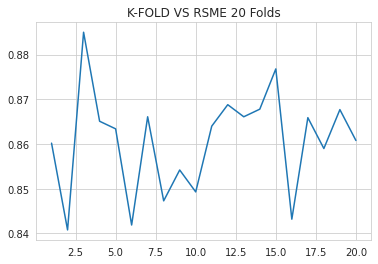

In [ ]:
# Plotting the relationship between K-folds and RSME Score @20 Folds 

def Rsme_kfold_1():
  Fold = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
  y = [0.8602, 0.8408, 0.8850, 0.8651, 0.8634, 0.8419, 0.8661, 0.8473, 0.8542, 0.8493, 0.8640, 0.8688, 0.8661, 0.8678, 0.8768, 0.8432, 0.8659, 0.8590, 0.8677, 0.8608]
  plt = sns.lineplot(x=Fold, y=y).set_title('K-FOLD VS RSME 20 Folds')
  return(plt)
  
Rsme_kfold_1()


Text(0.5, 1.0, 'K-FOLD VS RSME 50 Folds')

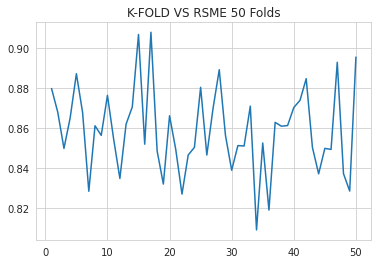

In [ ]:
# Plotting the relationship between K-folds and RSME Score @50 Folds 

def rsme_fold_2():
  Fold_1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
  y_1 = [0.8797, 0.8679, 0.8498, 0.8651, 0.8871, 0.8677, 0.8284, 0.8611, 0.8563, 0.8763, 0.8544, 0.8348, 0.8619, 0.8705, 0.9067, 0.8519, 0.9078, 0.8485
       , 0.8320, 0.8661, 0.8492, 0.8270, 0.8465, 0.8503, 0.8803, 0.8465, 0.8698, 0.8891, 0.8563, 0.8389, 0.8512, 0.8510, 0.8709, 0.8091, 0.8525, 0.8190
       , 0.8628, 0.8609, 0.8612, 0.8702, 0.8738, 0.8846, 0.8503, 0.8371, 0.8498, 0.8493, 0.8928, 0.8372, 0.8285, 0.8954]
  plt = sns.lineplot(x=Fold_1, y=y_1).set_title('K-FOLD VS RSME 50 Folds')

  return(plt)

rsme_fold_2()



In [ ]:
#Hyper-tuning SVD model 
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV

In [ ]:
#This is based on Randomsearch CV
data = Dataset.load_from_df(final_rating_content_based[['userId', 'movieId', 'rating']], reader)


param_grid_randomcv = {'n_epochs': [5, 10, 15, 20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

rs = RandomizedSearchCV(SVD,param_grid_randomcv,  cv=3)

rs.fit(data)

print(rs.best_score)

print(rs.best_params)

print(rs.cv_results)



In [ ]:
#This is based on Gridsearch CV 
data = Dataset.load_from_df(final_rating_content_based[['userId', 'movieId', 'rating']], reader)

param_grid = {'n_epochs': [5, 10, 15, 20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
gs.cv_results

In [ ]:
cross_validate(algo, data, measures=['RMSE','MAE'],cv=5, verbose=True)

Text(0.5, 1.0, 'RSME Comparison against benchmark')

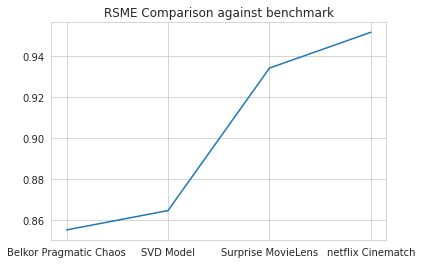

In [ ]:
#Plotting RSME score  

companies = ['netflix Cinematch', 'Belkor Pragmatic Chaos', 'Surprise MovieLens', 'SVD Model']
rsme_score_recorded = [0.9514, 0.8554, 0.934, 0.8648]

sns.lineplot(x = companies, y= rsme_score_recorded).set_title('RSME Comparison against benchmark')


In [ ]:
trainset = data.build_full_trainset()

algo.fit(trainset)

In [ ]:
#Rating given by user 200
final_rating_content_based[final_rating_content_based['userId'] == 200]

,userId,movieId,rating,timestamp
61,200,1196,5.0,1229886264
423,200,1,3.5,1229886312
574,200,1073,4.0,1229886286
1988,200,3793,4.0,1229885786
2221,200,2115,4.0,1229886375
...,...,...,...,...
86313,200,4722,3.0,1229878977
86314,200,5139,3.0,1229877842
86323,200,5610,2.0,1229877889
86326,200,27685,2.0,1229878742



Now let's use SVD to predict the rating that User with ID 200 will give to a random movie (let's say with Movie ID 1994).

In [ ]:
def predict_user_rating():
  
  a = algo.predict(200, 2751)
  b = algo.predict(200,1)
  return(a, b)

predict_user_rating()

(Prediction(uid=200, iid=2751, r_ui=None, est=4.035482025101063, details={'was_impossible': False}),
 Prediction(uid=200, iid=1, r_ui=None, est=4.099969637306036, details={'was_impossible': False}))

In [ ]:
algo.predict(200, 4722)

Prediction(uid=200, iid=4722, r_ui=None, est=3.4705837472189347, details={'was_impossible': False})

# Collaborative Filtering using ALS 

The ALS model works on implict data, impicit data is the indirect user interaction with an item, for example how many times a user views an item, or purchase history. 

In [ ]:
!pip install pyspark 

In [ ]:
!pip install implicit 

In [ ]:
import numpy as np 
import pandas as pd 
from scipy.sparse import csr_matrix
import implicit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#rsme for ALS 
sum = 90.54+ 87.54 + 92.54 + 88.94 + 88.10
average = sum/5
average

89.532

We need to create a Movie Title Mapper for our ALS Model 

In [ ]:
# Creating a Movie title Mapper using fuzzywuzzy 

def movie_finder(title):
  all_title = final_movie_content_based['title'].tolist()
  closet_match = process.extractOne(title, all_title)
  return closet_match[0]

movie_title_mapper = dict(zip(final_movie_content_based['title'], final_movie_content_based['movieId']))
movie_title_inv_mapper = dict(zip(final_movie_content_based['movieId'],final_movie_content_based['title']))

def get_movie_index(title):
  fuzzy_title = movie_finder(title)
  movie_id = movie_title_mapper[fuzzy_title]
  movie_idx = movie_mapper[movie_id]
  return movie_idx


def get_movie_title(movie_idx):
  movie_id = movie_inv_mapper[movie_idx]
  title = movie_title_inv_mapper[movie_id]
  return title 


In [ ]:
#Initalising the Model 

model_1_ALS = implicit.als.AlternatingLeastSquares(factors=100, use_cg=True, use_gpu=False, iterations=50, calculate_training_loss=True, num_threads=1,regularization=0.01)

model_1_ALS.fit(X)


In [ ]:
movie_of_interest = 'forrest gump'

movie_index = get_movie_index(movie_of_interest)
related = model_1_ALS.similar_items(movie_index)
related 

[(311, 0.33438691),
 (274, 0.19068725),
 (254, 0.16426249),
 (1922, 0.15873043),
 (415, 0.14940716),
 (507, 0.14936401),
 (95, 0.14337109),
 (511, 0.14030814),
 (433, 0.1270363),
 (960, 0.12667379)]

The output of similiar_items() is not user friendly, therefore we'll use get_movie_title to interept our results 

In [ ]:
print(f"Because you watched {movie_finder(movie_of_interest)}")
print(f"You may also like...")
for r in related:
  recommended_title = get_movie_title(r[0])
  if recommended_title != movie_finder(movie_of_interest):
    print(recommended_title)

Because you watched Forrest Gump (1994)
You may also like...
Shawshank Redemption, The (1994)
Pulp Fiction (1994)
Matrix, The (1999)
Jurassic Park (1993)
Silence of the Lambs, The (1991)
Braveheart (1995)
Pretty Woman (1990)
Mrs. Doubtfire (1993)
Back to the Future (1985)


Lets pull some personalised recommendations for users 

In [ ]:
#Lets pull personalised recommendations for user

user_id = 39

In [ ]:
user_ratings = final_rating_content_based[final_rating_content_based['userId']==user_id].merge(final_movie_content_based[['movieId', 'title', 'genres']])
user_ratings = user_ratings.sort_values('rating', ascending=False)
print(f"Number of movies rated by user {user_id}: {user_ratings['movieId'].nunique()}")

Number of movies rated by user 39: 100


In [ ]:
user_ratings = final_rating_content_based[final_rating_content_based['userId']==user_id].merge(final_movie_content_based[['movieId', 'title','genres']])
user_ratings = user_ratings.sort_values('rating', ascending=False).drop_duplicates('title')
top_5 = user_ratings.head()
top_5

,userId,movieId,rating,timestamp,title,genres
0,39,1196,5.0,974789111,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]"
4076,39,1214,5.0,974787510,Alien (1979),"[Horror, Sci-Fi]"
4284,39,1210,5.0,974787586,Star Wars: Episode VI - Return of the Jedi (1983),"[Action, Adventure, Sci-Fi]"
2755,39,2858,5.0,974788291,American Beauty (1999),"[Drama, Romance]"
3657,39,260,5.0,974787510,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]"


In [ ]:
bottom_5 = user_ratings[user_ratings['rating']<3].tail()
bottom_5

,userId,movieId,rating,timestamp,title,genres
667,39,1954,2.0,974789327,Rocky (1976),[Drama]
6425,39,924,2.0,974787586,2001: A Space Odyssey (1968),"[Adventure, Drama, Sci-Fi]"
7632,39,3418,2.0,974789327,Thelma & Louise (1991),"[Adventure, Crime, Drama]"
3392,39,2137,1.0,974788976,Charlotte's Web (1973),"[Animation, Children]"
1674,39,1282,1.0,974788629,Fantasia (1940),"[Animation, Children, Fantasy, Musical]"


Using Apache Spark to evalute the ALS model

In [ ]:
#Loading all the relevant libraries for ALS 

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.sql import SparkSession


In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
spark = SparkSession.builder.appName('Recommendation_system')

In [ ]:
final_rating_content_based.head()

final_rating = final_rating_content_based.drop(labels=["timestamp"], axis=1)

final_rating.head()

,userId,movieId,rating
0,1,1196,5.0
1,4,1196,5.0
2,7,1196,4.0
3,15,1196,5.0
4,16,1196,3.0


In [ ]:
!pip install pandas==1.1.2

In [ ]:
weights = [0.8,0.2]

In [ ]:
als_model_pyspark = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

In [ ]:
param_grid_als = ParamGridBuilder()\
                 .addGrid(als_model_pyspark.rank, [12, 13, 14])\
                 .addGrid(als_model_pyspark.maxIter, [18, 19, 20])\
                 .addGrid(als_model_pyspark.regParam, [.17, .18, .19])\
                 .build()

evaluator = RegressionEvaluator(metricName="rsme", labelCol="rating", predictionCol="prediction")

cv_for_als = CrossValidator(estimator=als_model_pyspark, estimatorParamMaps=param_grid_als, evaluator=evaluator, numFolds=3, seed=3421)


In [ ]:
model_als_fit = cv_for_als.fit(final_rating)